# 변수선택을 해봅시다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, Ridge, Lasso

from bayes_opt import BayesianOptimization

from sklearn.model_selection import KFold

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Preprocessing

In [2]:
PATH = r'C:\Users\Wyatt\wyatt37\data\energy'

In [3]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [4]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')

In [5]:
def make_time(train):
    train['date_time'] = pd.to_datetime(train.date_time)
    
    # 1차 time / 지지
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 시(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    train['weekofyear'] = train.date_time.dt.isocalendar().week  # 연 기준 몇주째(숫자) (=week)
    
    # 2차 time / 지지
    train['month_start'] = train.date_time.dt.is_month_start
    train['month_end'] = train.date_time.dt.is_month_end
    
    # 여기까지
    
    #train.drop(['date_time', 'datetime'], axis=1, inplace=True)
    
    train.weekofyear = train.weekofyear.astype(int)
    
    return train

In [6]:
train = make_time(train)
test = make_time(test)

In [7]:
# cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [8]:
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [9]:
# 6월 6일은 현충일
# 8월 15일은 광복절
# 8월 17일은 임시공휴일

# 휴일이 많지 않으니, 주말에 포함시키자.

train.loc[train.weekday >= 5, 'holiday'] = True
train.loc[train.weekday < 5, 'holiday'] = False
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = True

test.loc[test.weekday >= 5, 'holiday'] = True
test.loc[test.weekday < 5, 'holiday'] = False

train.holiday = train.holiday.astype('bool')
test.holiday = test.holiday.astype('bool')

In [10]:
train

num           date_time    target  temp  wind  humid  rain  sunny  \
0         1 2020-06-01 00:00:00  8179.056  17.6   2.5   92.0   0.8    0.0   
1         1 2020-06-01 01:00:00  8135.640  17.7   2.9   91.0   0.3    0.0   
2         1 2020-06-01 02:00:00  8107.128  17.5   3.2   91.0   0.0    0.0   
3         1 2020-06-01 03:00:00  8048.808  17.1   3.2   91.0   0.0    0.0   
4         1 2020-06-01 04:00:00  8043.624  17.0   3.3   92.0   0.0    0.0   
...     ...                 ...       ...   ...   ...    ...   ...    ...   
122395   60 2020-08-24 19:00:00  4114.368  27.8   2.3   68.0   0.0    0.7   
122396   60 2020-08-24 20:00:00  3975.696  27.3   1.2   71.0   0.0    0.0   
122397   60 2020-08-24 21:00:00  3572.208  27.3   1.8   71.0   0.0    0.0   
122398   60 2020-08-24 22:00:00  3299.184  27.1   1.8   74.0   0.0    0.0   
122399   60 2020-08-24 23:00:00  3204.576  27.1   2.6   75.0   0.0    0.0   

        cooler  solar  month  day  hour  weekday  dayofyear  weekofyear  \
0          0.0    0.0      6    1     0        0        153          23   
1          0.0    0.0      6    1     1        0        153          23   
2          0.0    0.0      6    1     2        0        153          23   
3          0.0    0.0      6    1     3        0        153          23   
4          0.0    0.0      6    1     4        0        153          23   
...        ...    ...    ...  ...   ...      ...        ...         ...   
122395     1.0    1.0      8   24    19        0        237          35   
122396     1.0    1.0      8   24    20        0        237          35   
122397     1.0    1.0      8   24    21        0        237          35   
122398     1.0    1.0      8   24    22        0        237          35   
122399     1.0    1.0      8   24    23        0        237          35   

        month_start  month_end  holiday  
0              True      False    False  
1              True      False    False  
2              True      False    False  
3              True      False    False  
4              True      False    False  
...             ...        ...      ...  
122395        False      False    False  
122396        False      False    False  
122397        False      False    False  
122398        False      False    False  
122399        False      False    False  

[122400 rows x 19 columns]

In [17]:
train.head()

num           date_time    target  temp  wind  humid  rain  sunny  cooler  \
0    1 2020-06-01 00:00:00  8179.056  17.6   2.5   92.0   0.8    0.0     0.0   
1    1 2020-06-01 01:00:00  8135.640  17.7   2.9   91.0   0.3    0.0     0.0   
2    1 2020-06-01 02:00:00  8107.128  17.5   3.2   91.0   0.0    0.0     0.0   
3    1 2020-06-01 03:00:00  8048.808  17.1   3.2   91.0   0.0    0.0     0.0   
4    1 2020-06-01 04:00:00  8043.624  17.0   3.3   92.0   0.0    0.0     0.0   

   solar  month  day  hour  weekday  dayofyear  weekofyear  month_start  \
0    0.0      6    1     0        0        153          23         True   
1    0.0      6    1     1        0        153          23         True   
2    0.0      6    1     2        0        153          23         True   
3    0.0      6    1     3        0        153          23         True   
4    0.0      6    1     4        0        153          23         True   

   month_end  holiday  
0      False    False  
1      False    False  
2      False    False  
3      False    False  
4      False    False

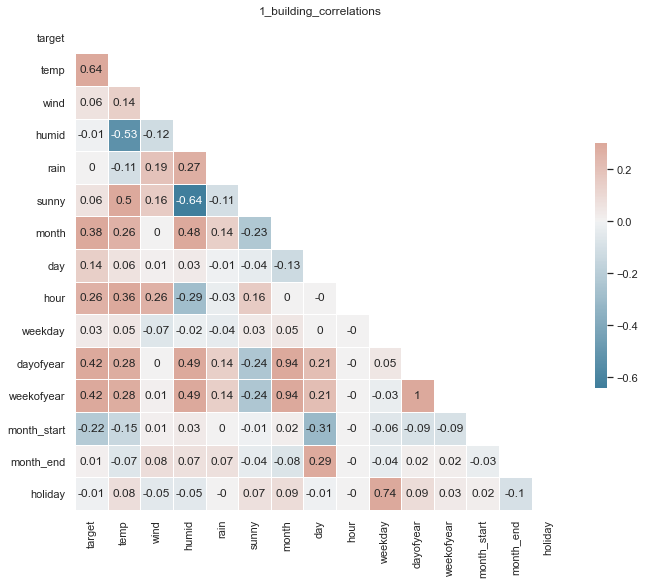

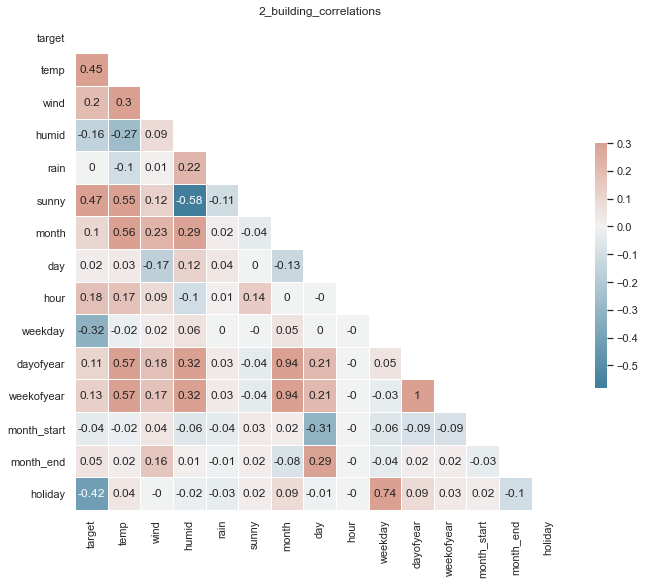

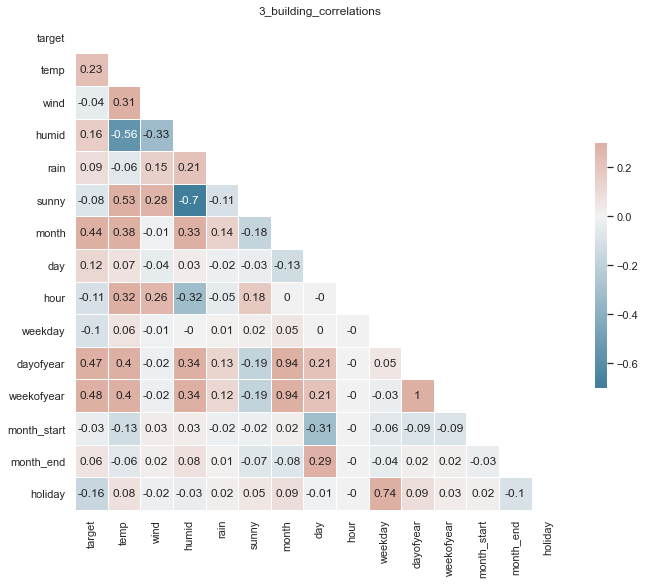

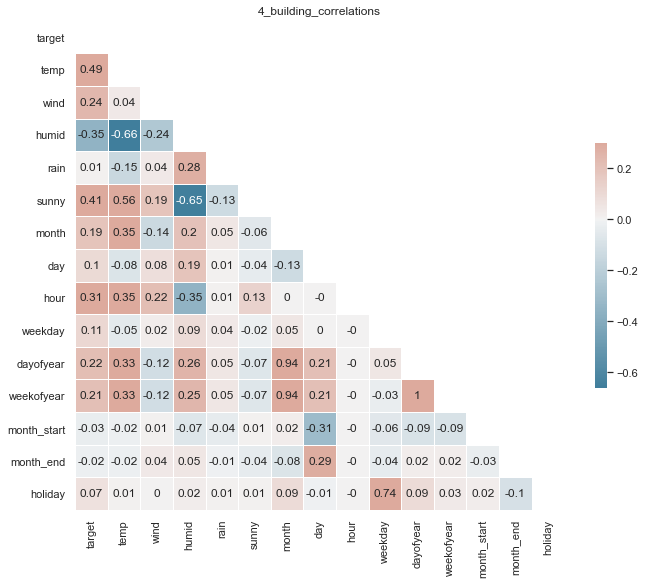

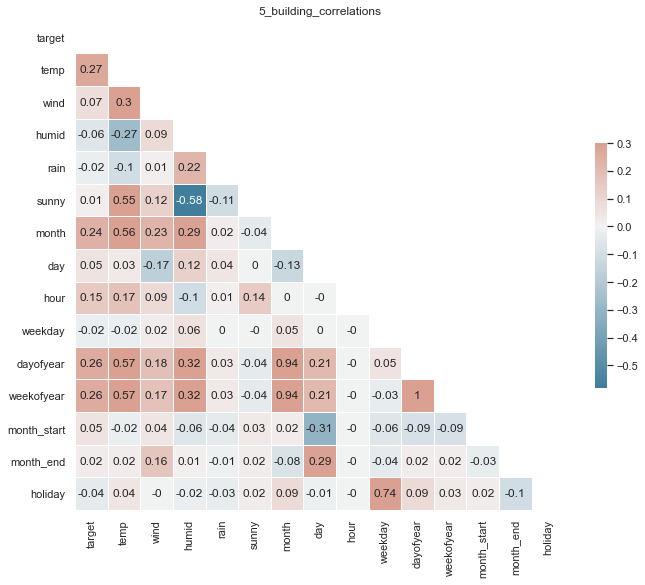

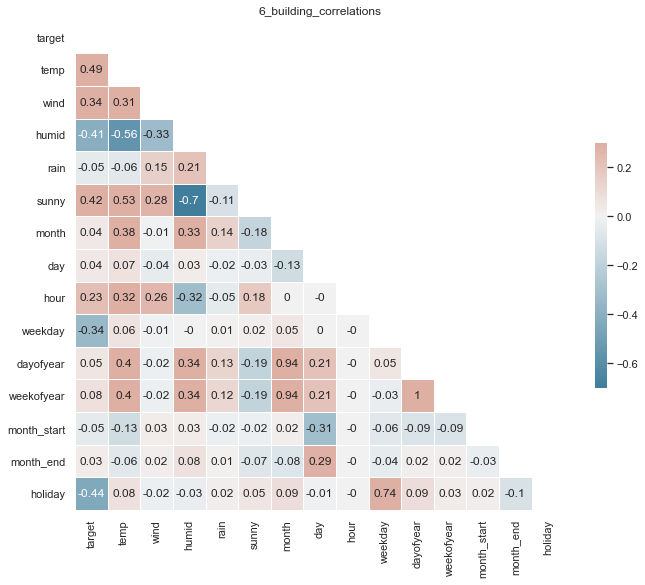

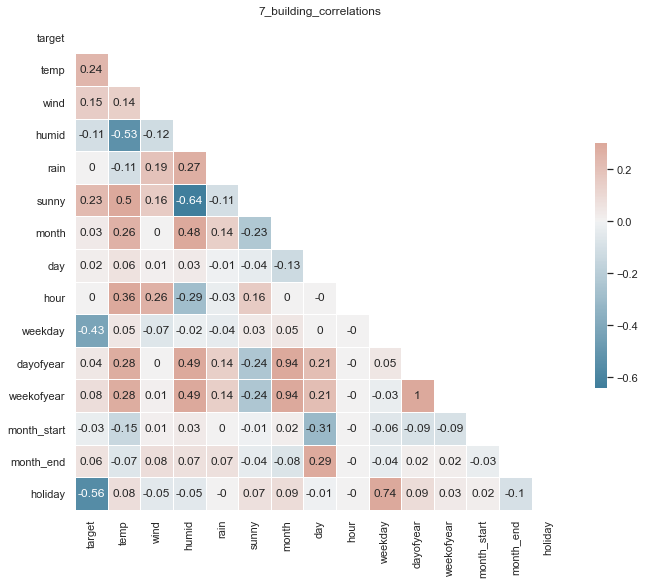

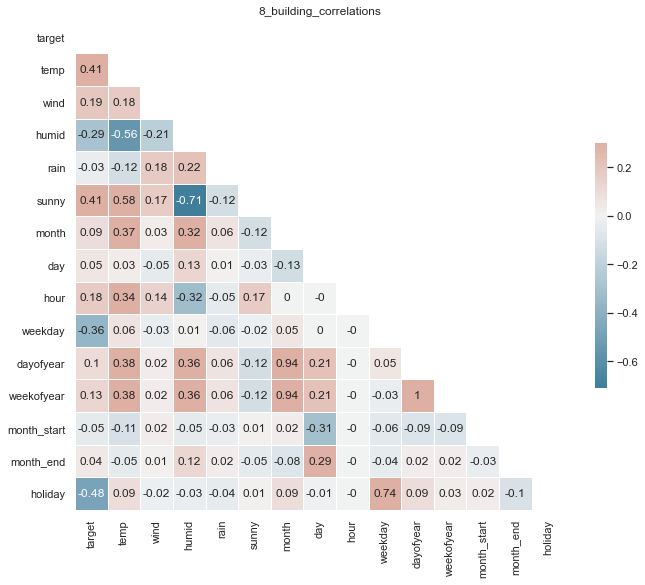

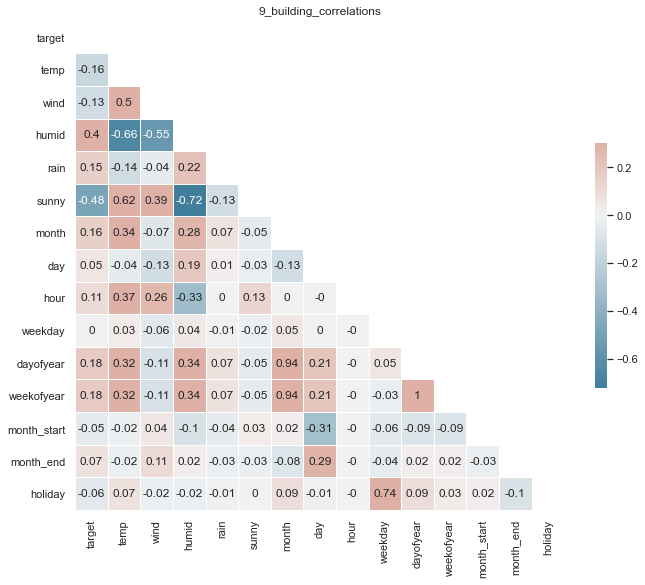

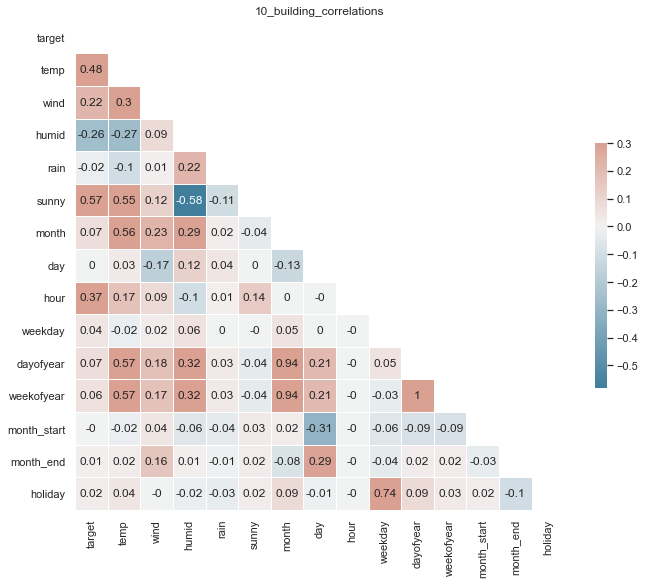

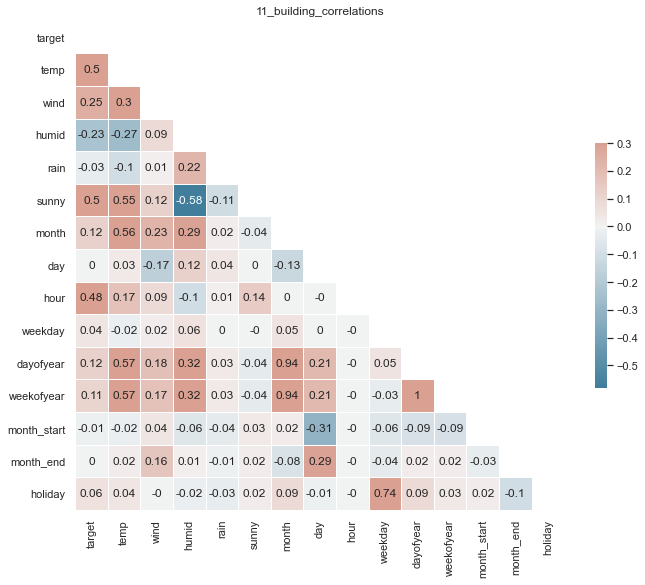

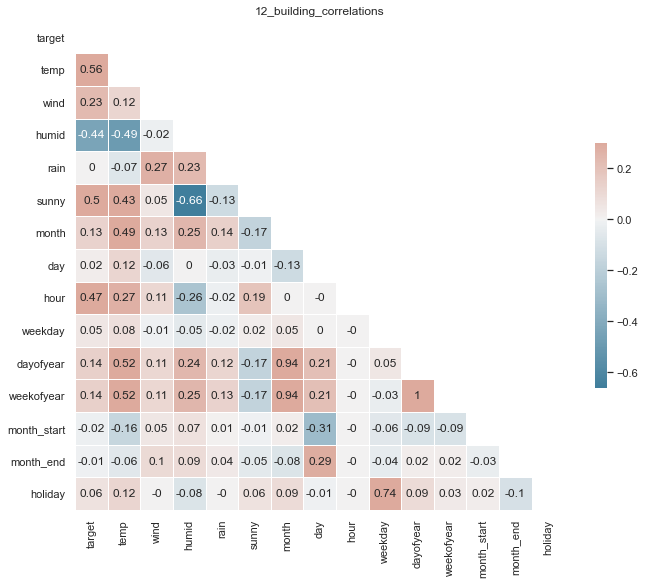

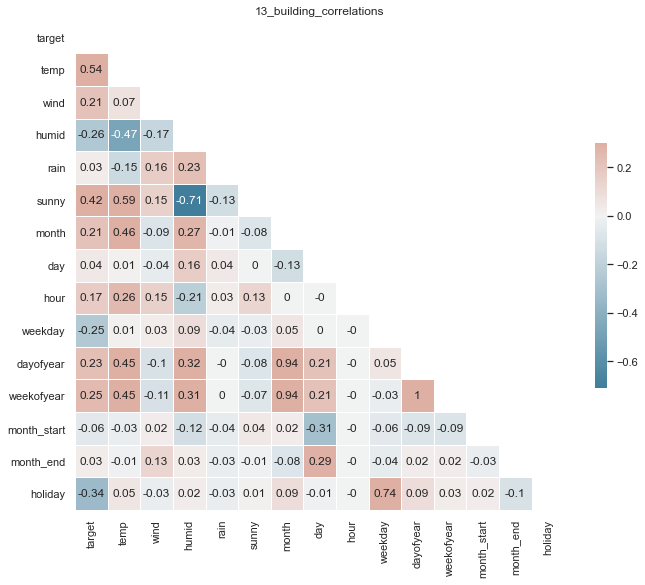

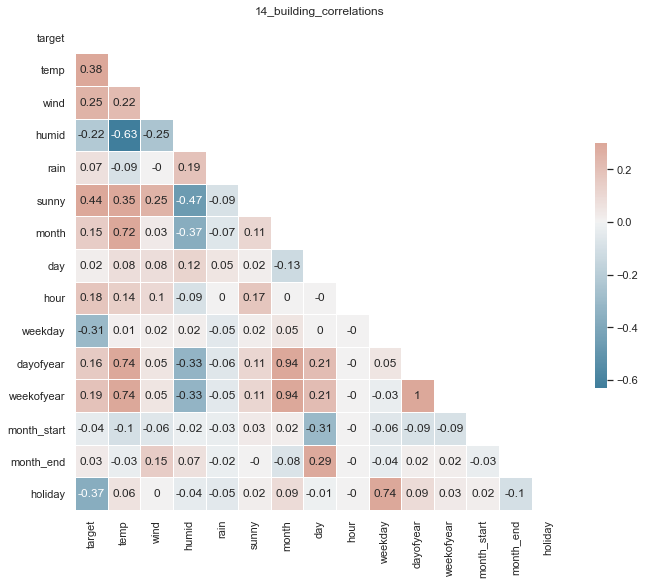

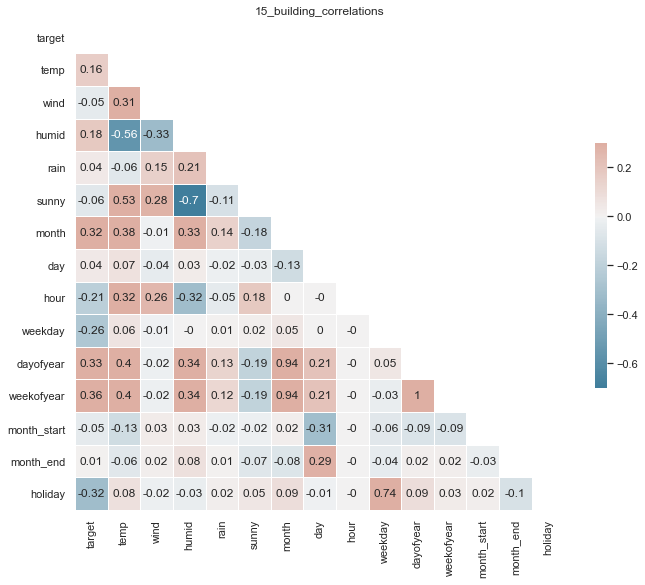

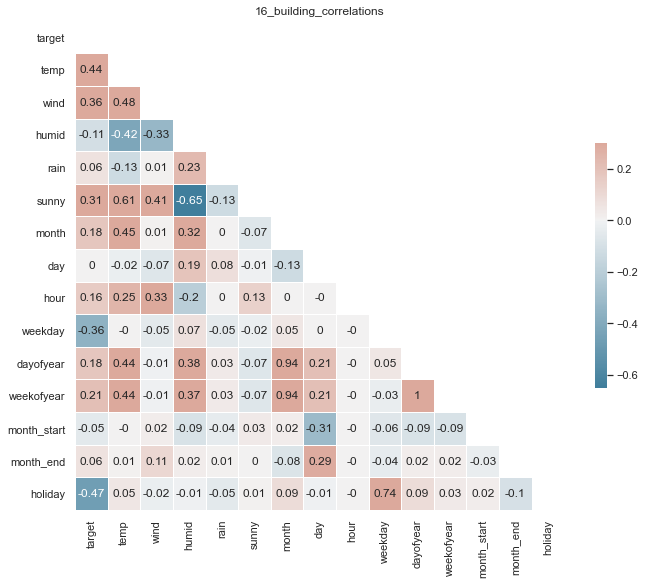

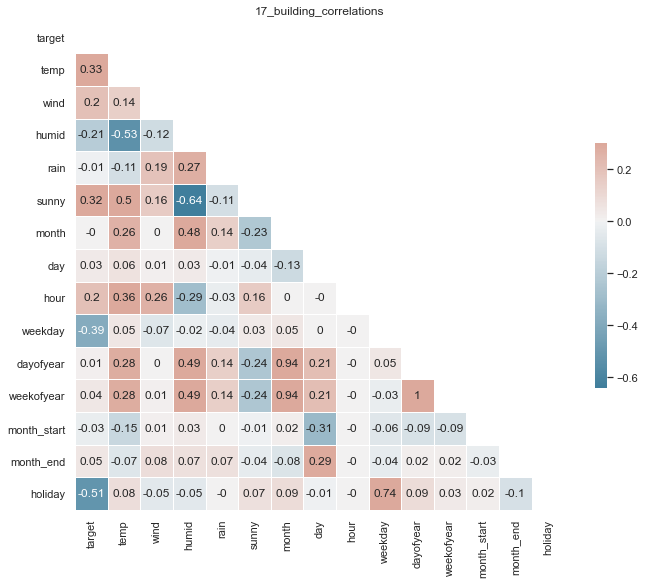

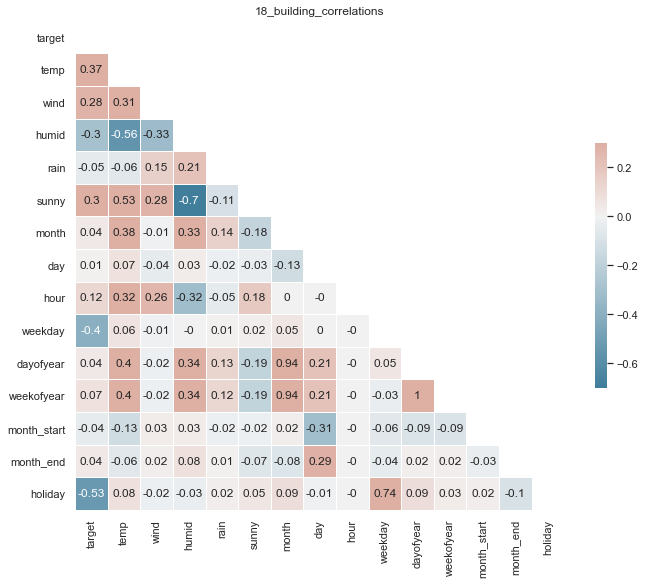

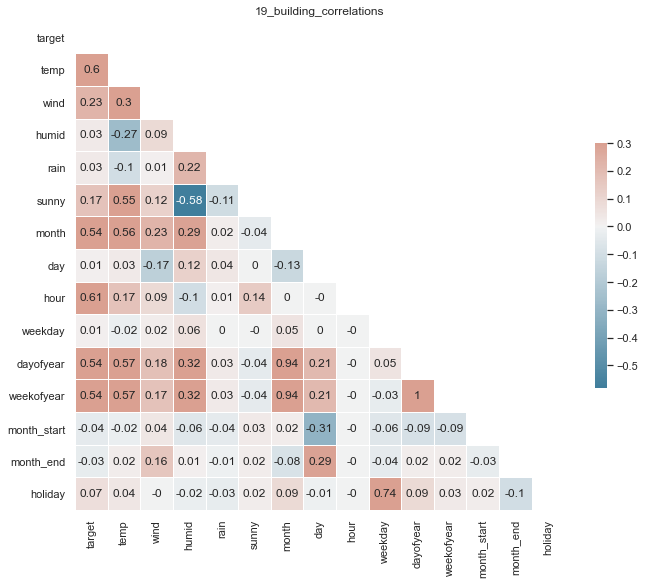

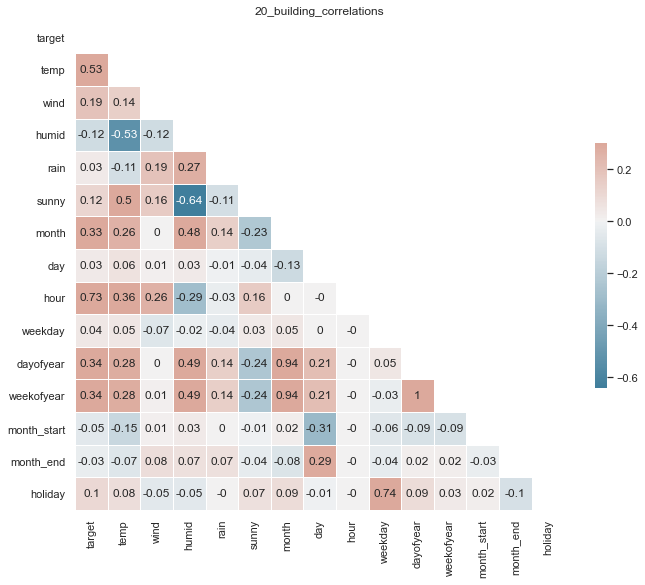

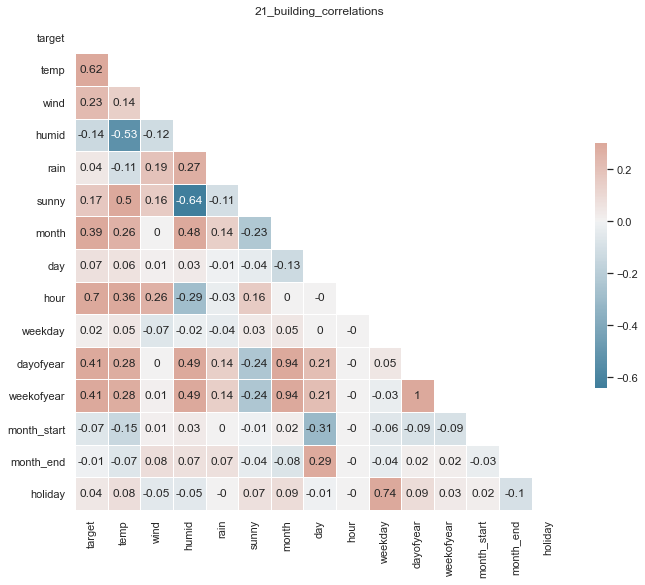

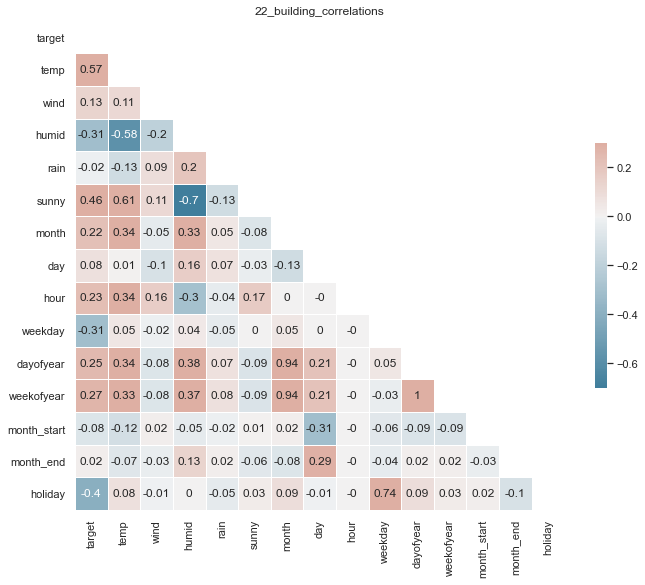

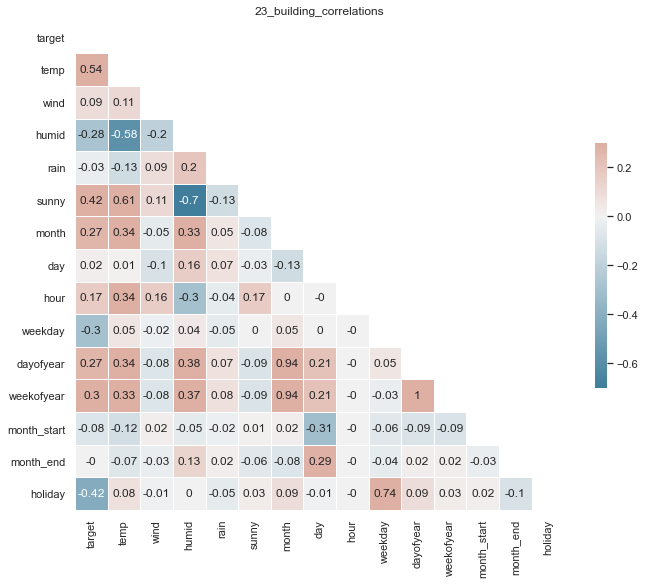

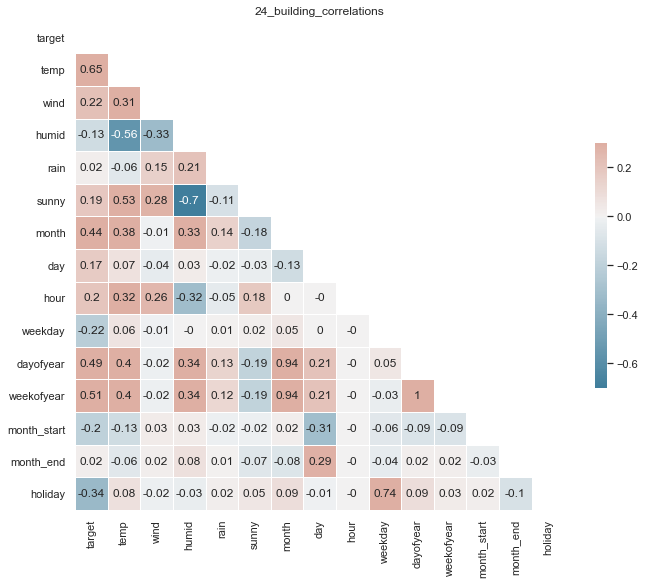

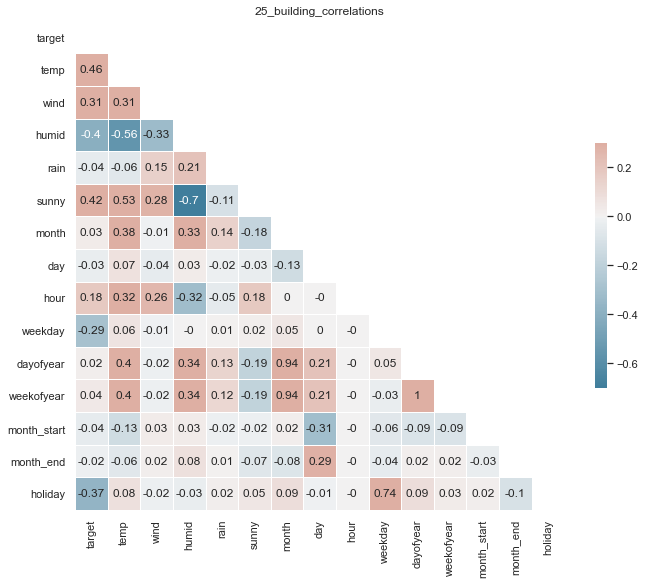

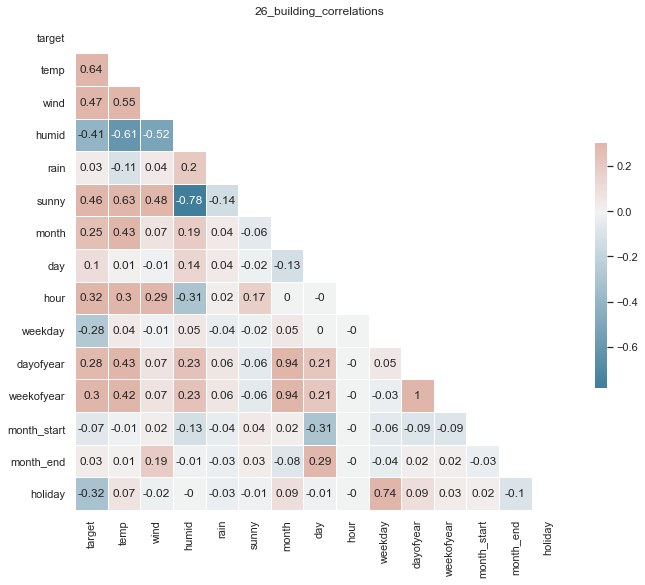

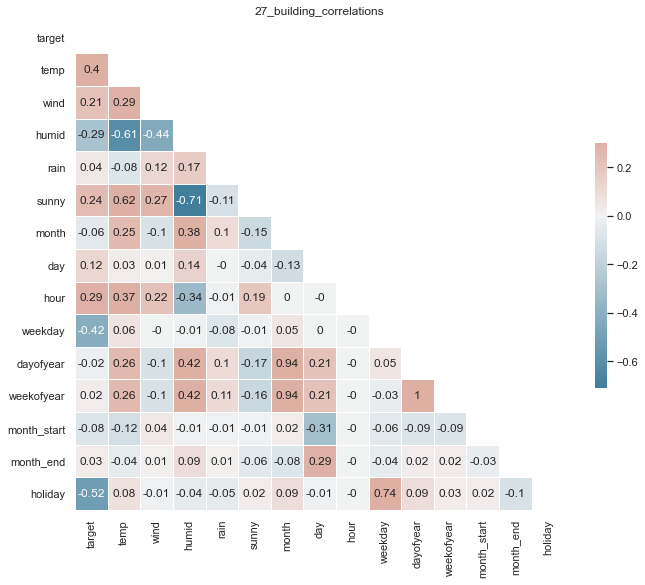

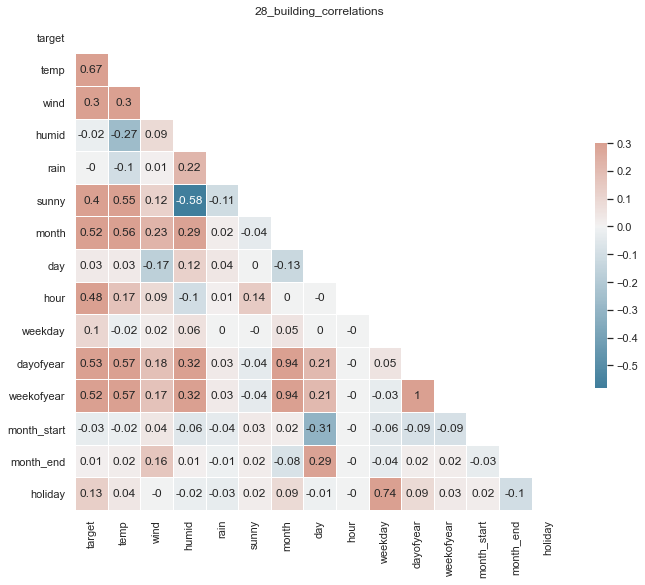

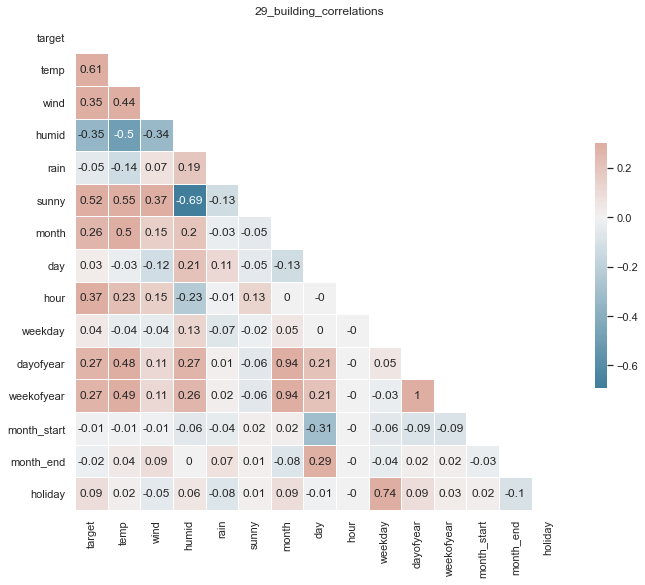

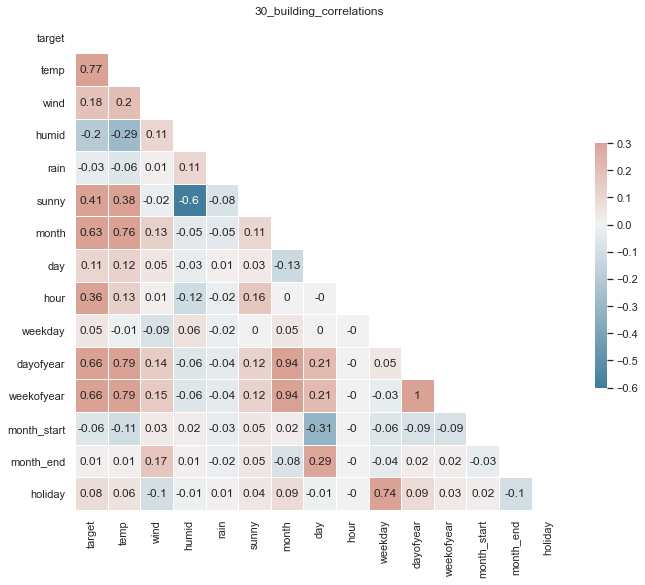

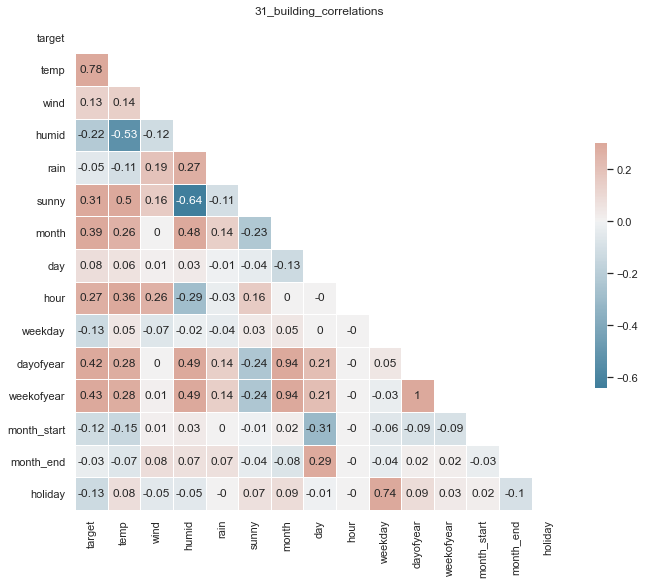

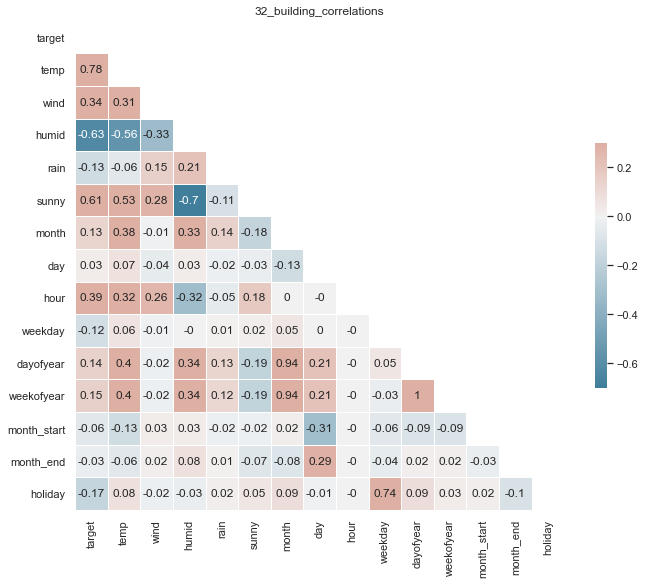

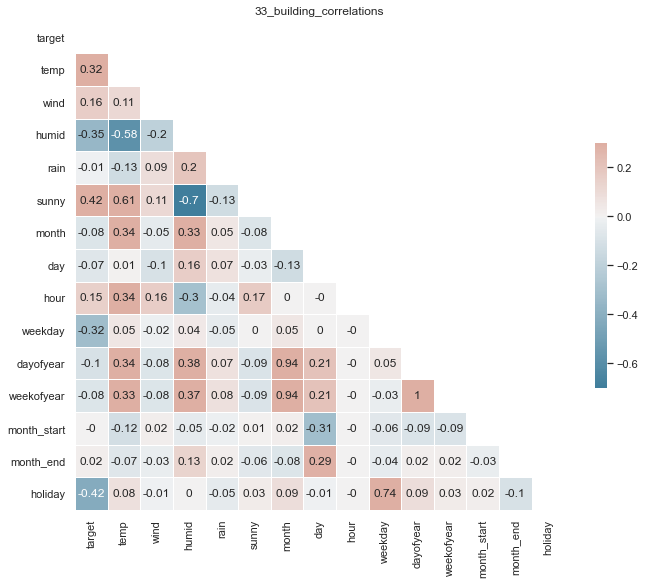

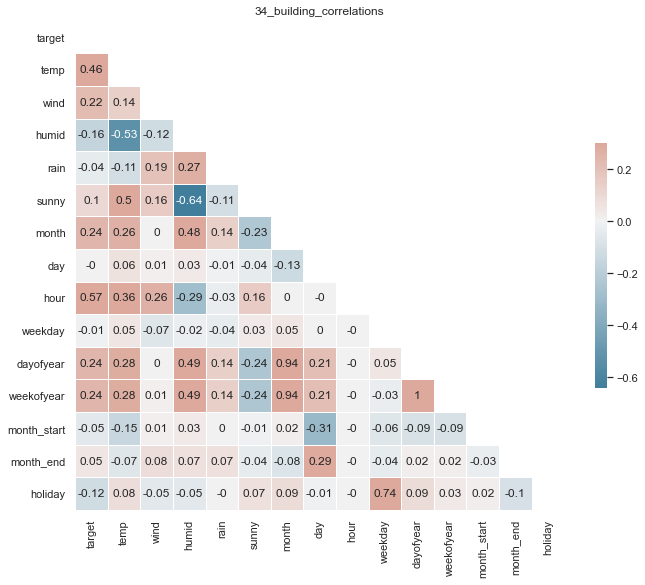

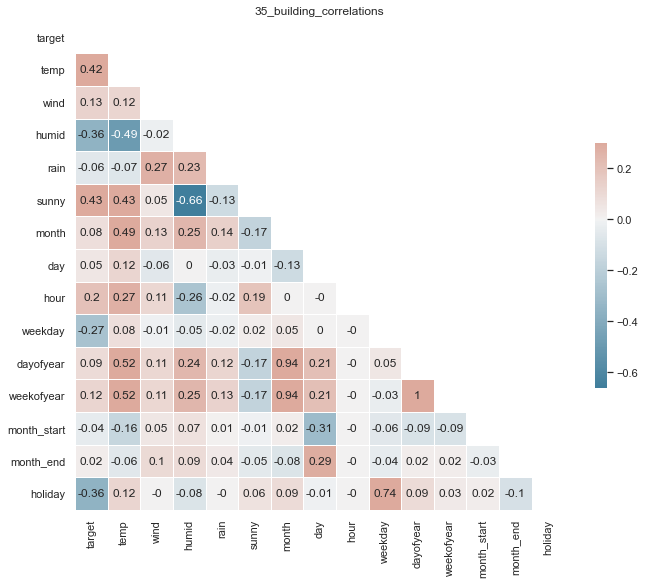

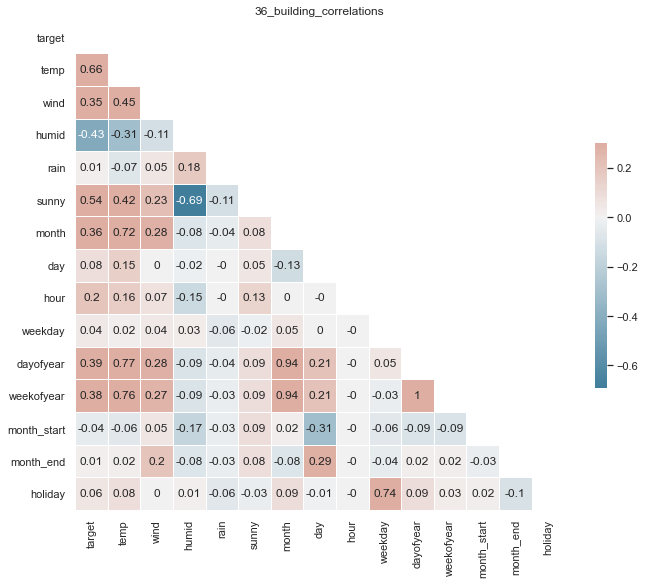

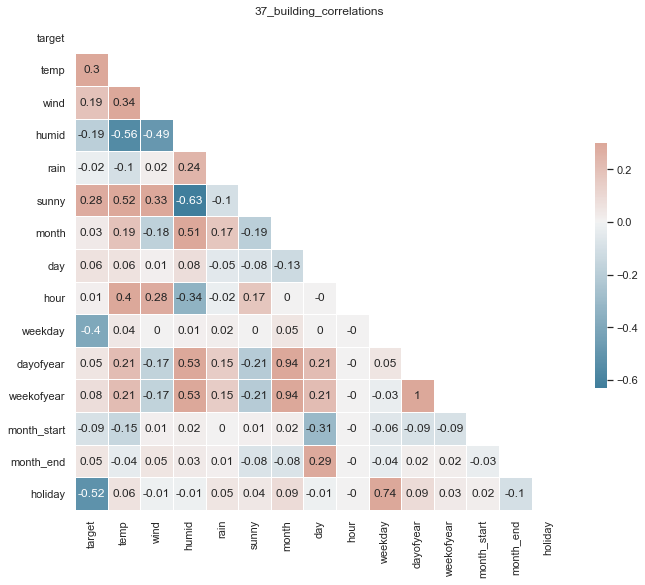

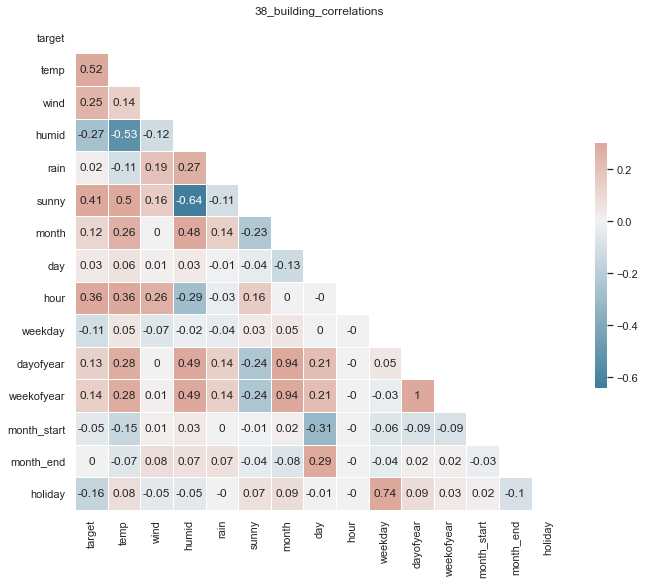

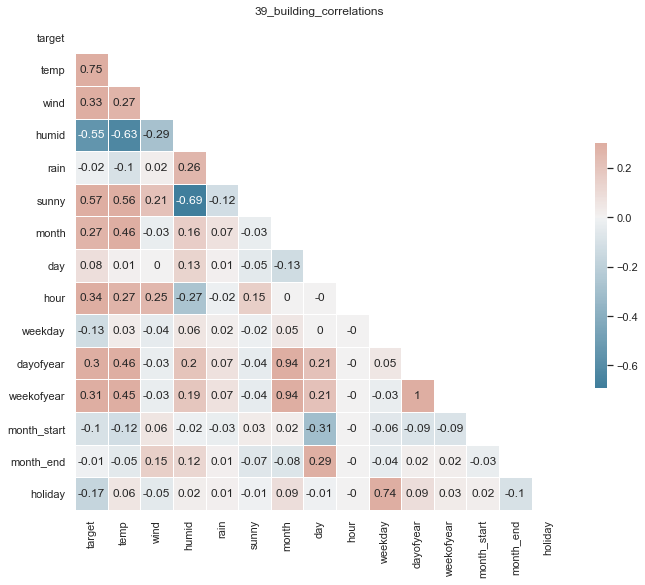

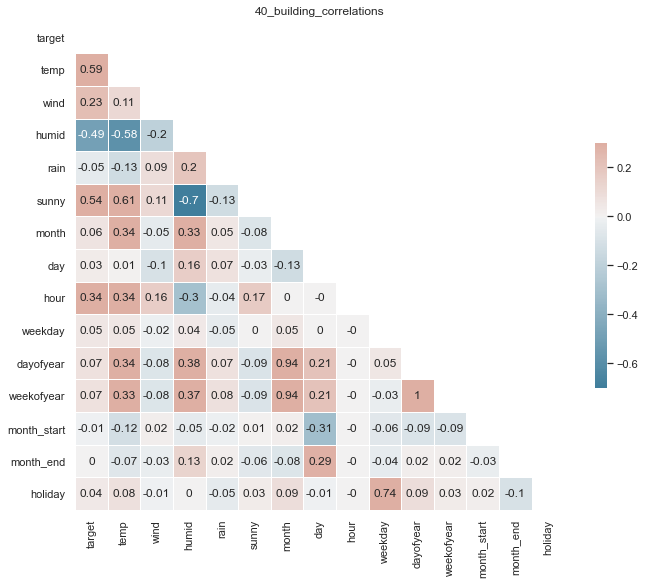

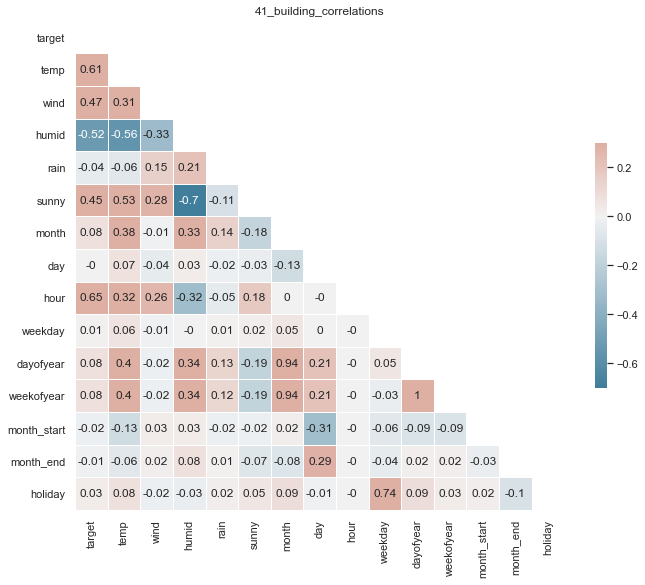

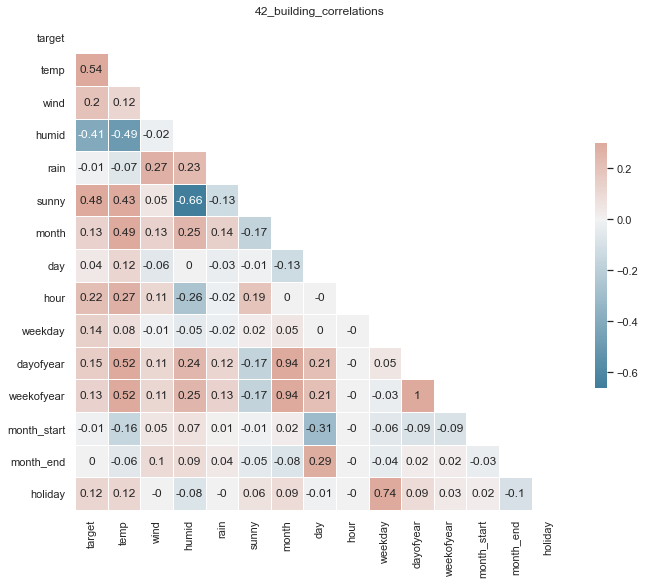

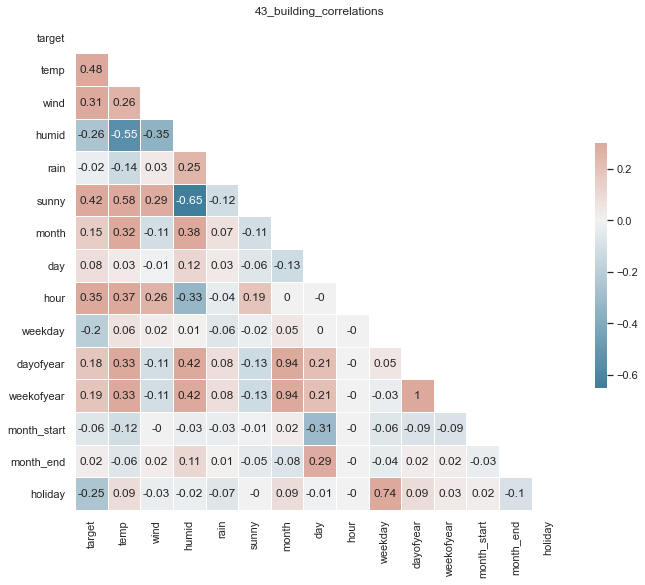

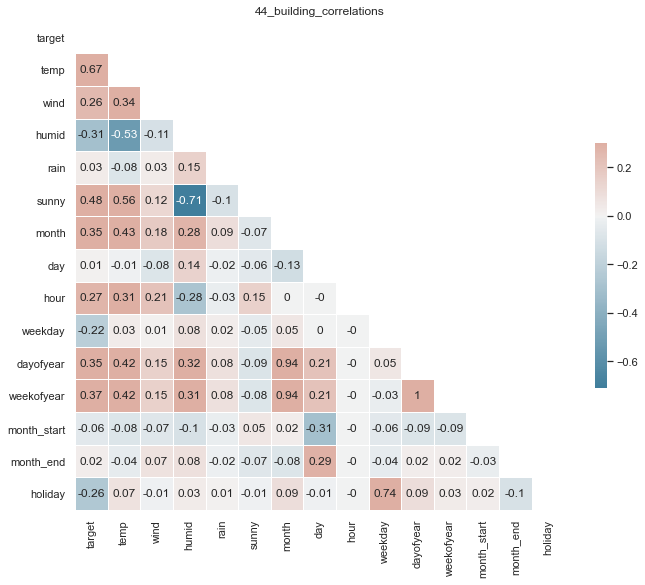

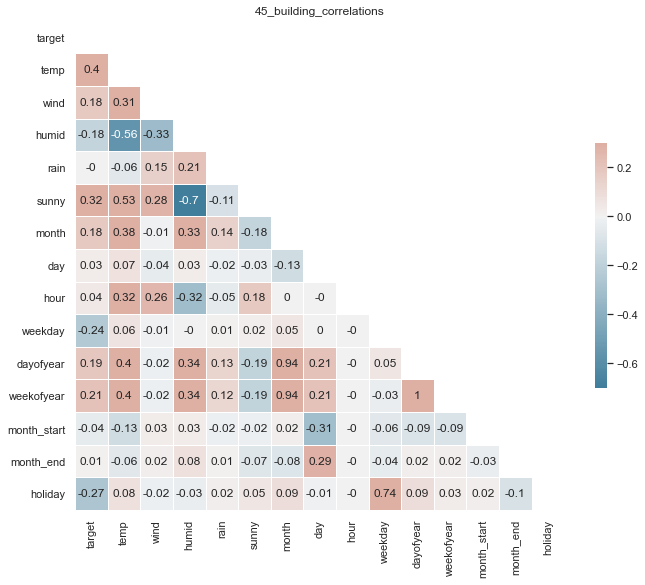

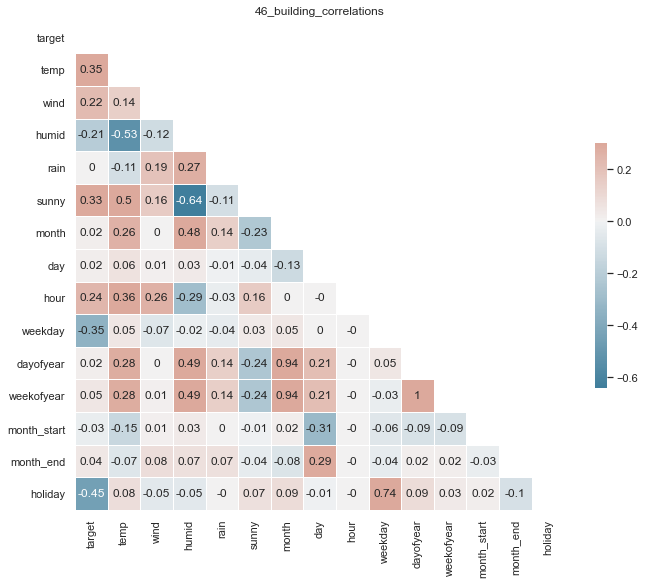

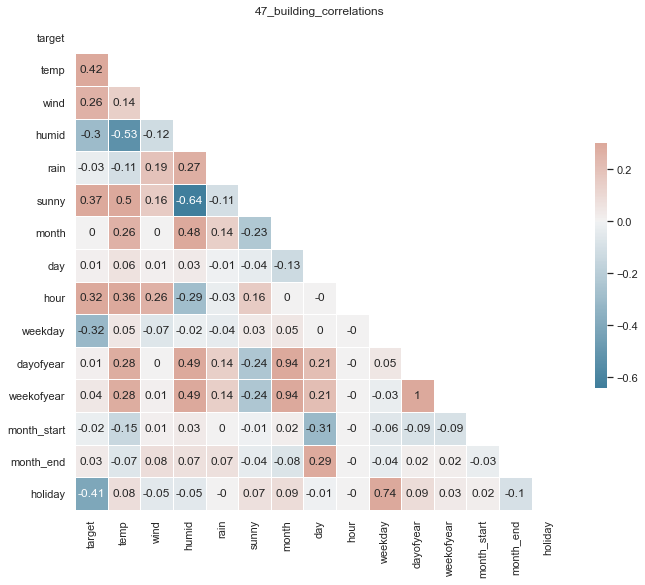

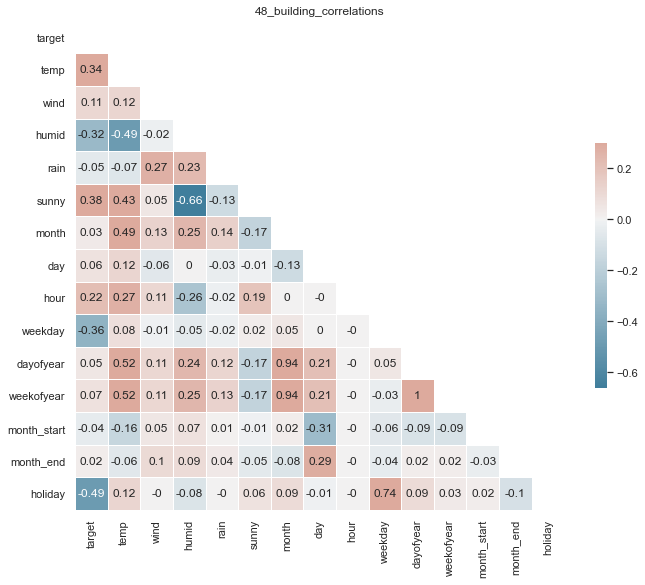

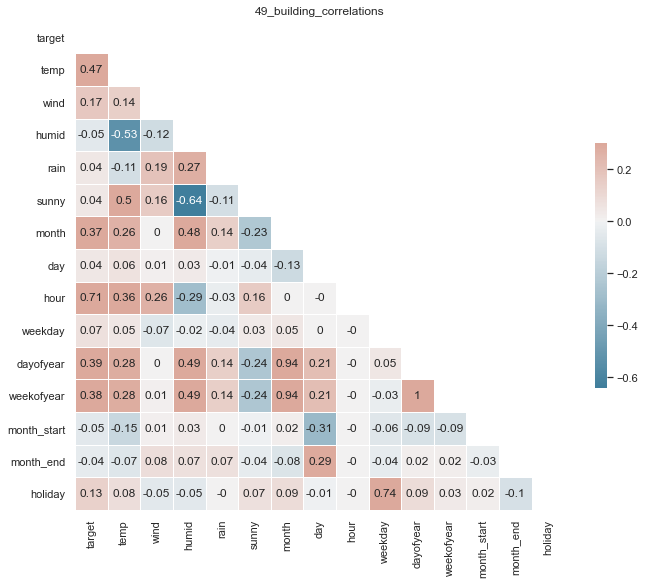

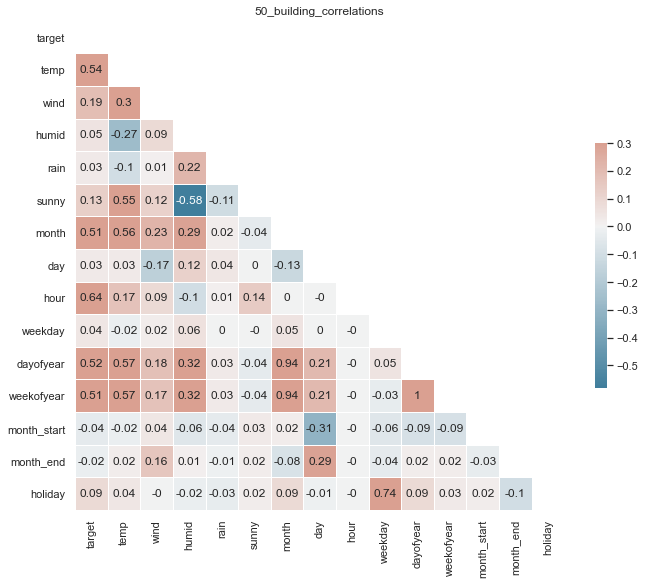

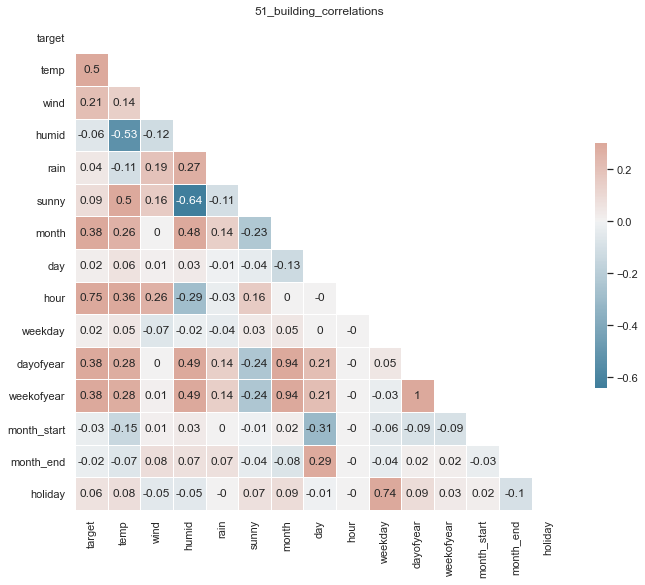

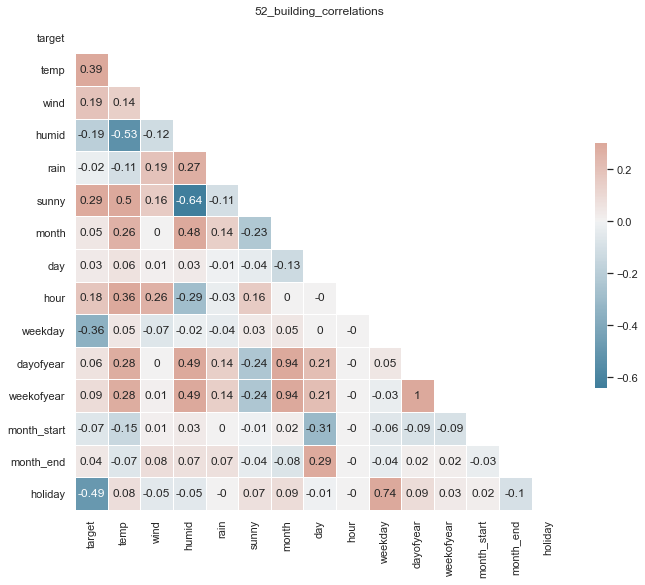

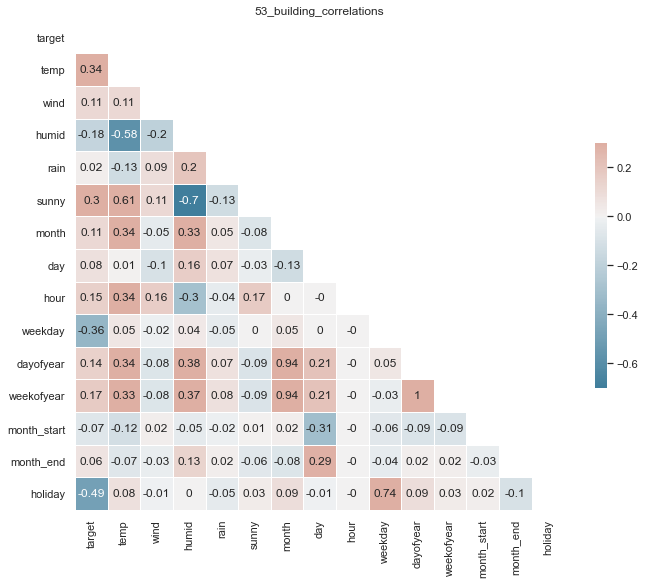

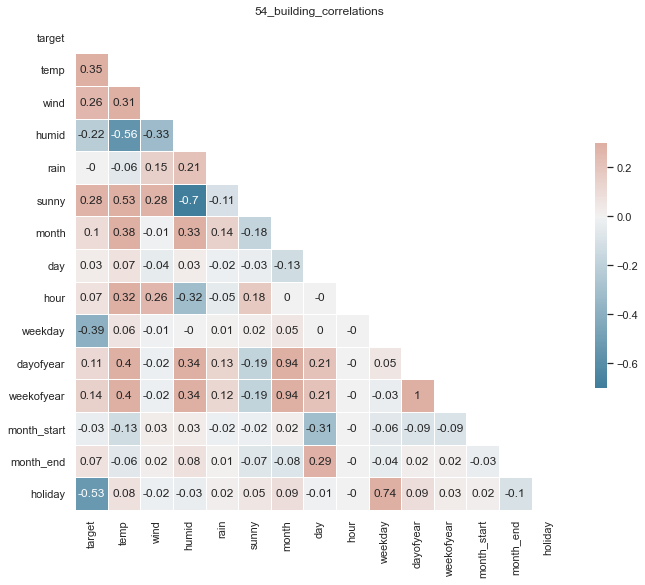

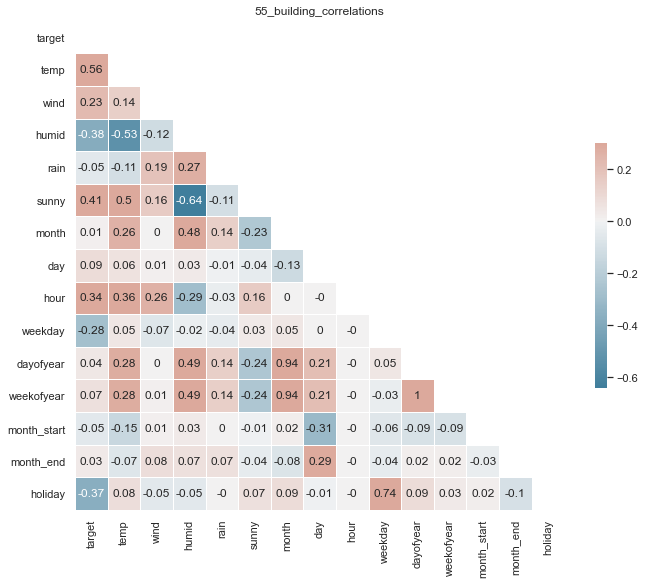

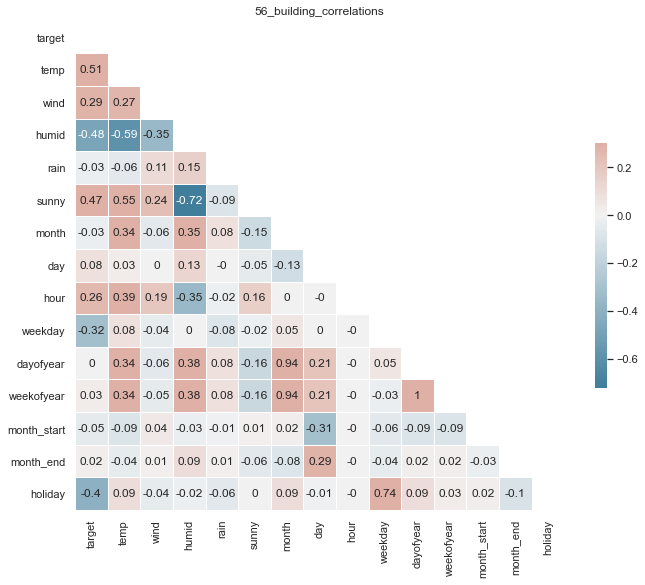

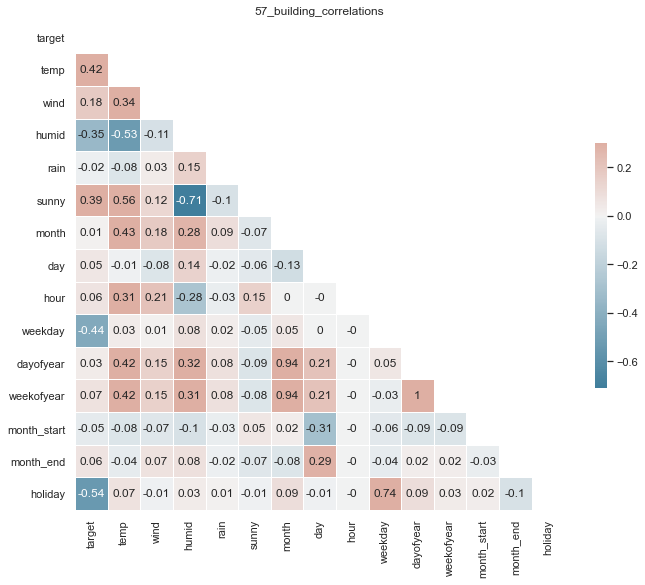

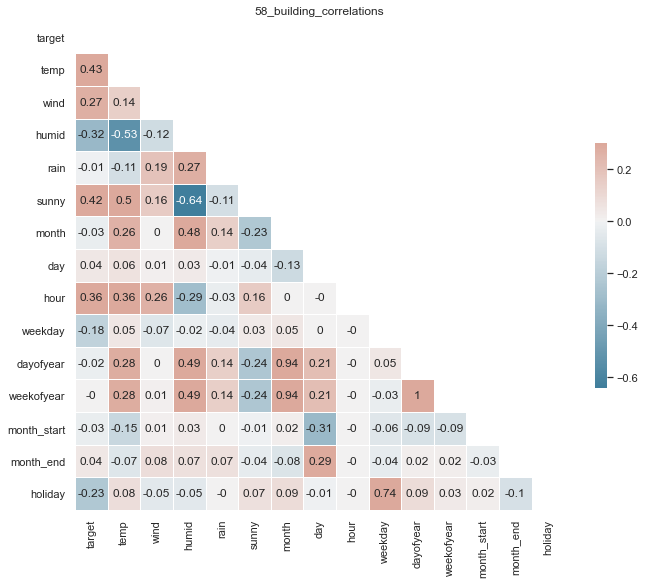

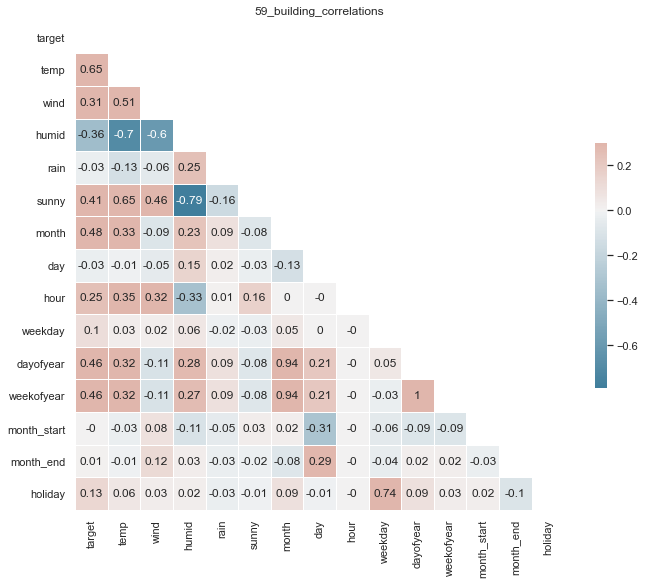

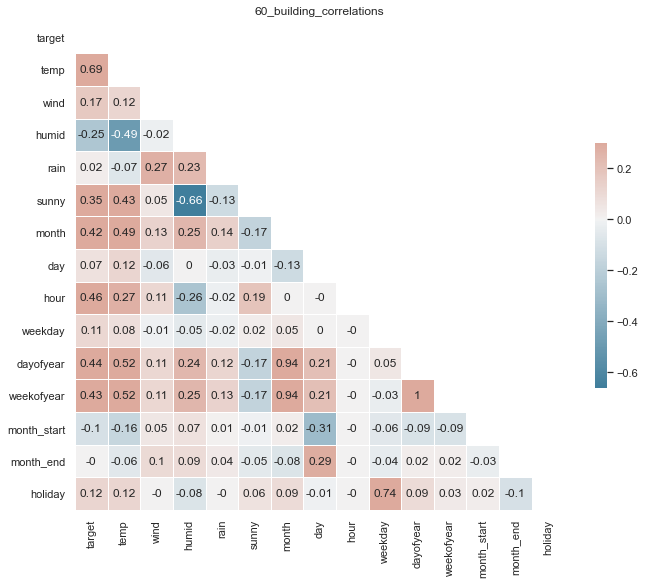

In [22]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(1, 61):
    sns.set_theme(style="white")

    # Generate a large random dataset
    # rs = np.random.RandomState(33)
    # d = pd.DataFrame(data=rs.normal(size=(100, 26)),
    #                  columns=list(ascii_letters[26:]))

    # Compute the correlation matrix
    corr = train.loc[train.num == i, ~train.columns.isin(['num', 'date_time', 'cooler', 'solar'])].corr().round(2)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('{}_building_correlations'.format(i))
    plt.show()